# Load Library

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [31]:
def load_rgb(path: str):
    bgr = cv2.imread(path)
    if bgr is None:
        raise FileNotFoundError(f"Tidak bisa load: {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def save_rgb(img_rgb: np.ndarray, path: str):
    path = str(path)
    bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, bgr)

def show_grid(images, titles=None, ncols=4, figsize=(14, 9), suptitle=None):
    titles = titles or [""] * len(images)
    n = len(images)
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=figsize)
    if suptitle:
        plt.suptitle(suptitle, fontsize=14)
    for i, (im, t) in enumerate(zip(images, titles), 1):
        ax = plt.subplot(nrows, ncols, i)
        ax.imshow(im)
        ax.set_title(t, fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def save_version(img, name, out_dir="./outputs_spatial"):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    path = Path(out_dir) / f"{name}.jpg"
    cv2.imwrite(str(path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    return path


# Load Data and Preview

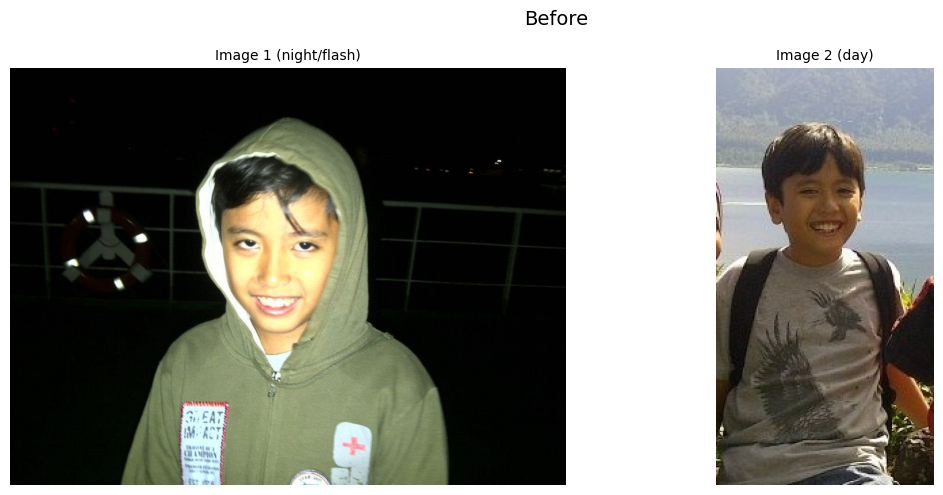

In [32]:
# Path file
IMG1_PATH = "image2.jpg"
IMG2_PATH = "image1.jpg"

# Folder output
OUT_DIR = Path("./outputs_spatial")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Parameter sweep (bebas diubah)
CLAHE_PARAMS = [(1.0, 8), (1.6, 8), (2.0, 8), (3.0, 8), (2.0, 4), (2.0, 12)]
UNSHARP_PARAMS = [(1, 0.5), (2, 0.8), (3, 1.0), (5, 1.2)]
BILATERAL_PARAMS = [(7, 30, 30), (9, 50, 50), (11, 70, 70)]
MEDIAN_PARAMS = [3, 5, 7]
GAMMA_VALS = [0.8, 1.0, 1.2, 1.4]
CS_PARAMS = [(2, 98), (1, 99), (0.5, 99.5)]  # (low_percent, high_percent)

# Load
img1 = load_rgb(IMG1_PATH)
img2 = load_rgb(IMG2_PATH)

show_grid([img1, img2], ["Image 1 (night/flash)", "Image 2 (day)"], ncols=2, figsize=(12,5), suptitle="Before")


In [33]:
def gamma_correction(img_rgb, gamma=1.0):
    inv = 1.0 / max(gamma, 1e-6)
    table = (np.arange(256) / 255.0) ** inv
    table = np.clip(table * 255.0, 0, 255).astype(np.uint8)
    return cv2.LUT(img_rgb, table)

def contrast_stretch(img_rgb, low_percent=1, high_percent=99):
    out = img_rgb.copy().astype(np.float32)
    for c in range(3):
        lo = np.percentile(out[..., c], low_percent)
        hi = np.percentile(out[..., c], high_percent)
        if hi - lo < 1e-6:
            continue
        out[..., c] = (out[..., c] - lo) * (255.0 / (hi - lo))
        out[..., c] = np.clip(out[..., c], 0, 255)
    return out.astype(np.uint8)

def clahe_on_luma(img_rgb, clip_limit=2.0, tile_grid_size=8):
    ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit),
                            tileGridSize=(int(tile_grid_size), int(tile_grid_size)))
    Y2 = clahe.apply(Y)
    return cv2.cvtColor(cv2.merge([Y2, Cr, Cb]), cv2.COLOR_YCrCb2RGB)

def unsharp_mask(img_rgb, radius=3, amount=1.0):
    ksize = max(1, int(radius) * 2 + 1)
    blur = cv2.GaussianBlur(img_rgb, (ksize, ksize), 0)
    return cv2.addWeighted(img_rgb, 1 + float(amount), blur, -float(amount), 0)

def bilateral_denoise(img_rgb, d=9, sigmaColor=50, sigmaSpace=50):
    return cv2.bilateralFilter(img_rgb, int(d), float(sigmaColor), float(sigmaSpace))

def median_denoise(img_rgb, ksize=3):
    k = int(ksize) if int(ksize) % 2 == 1 else int(ksize) + 1
    return cv2.medianBlur(img_rgb, k)


# Metode 1 - Parameter Sweep – CLAHE

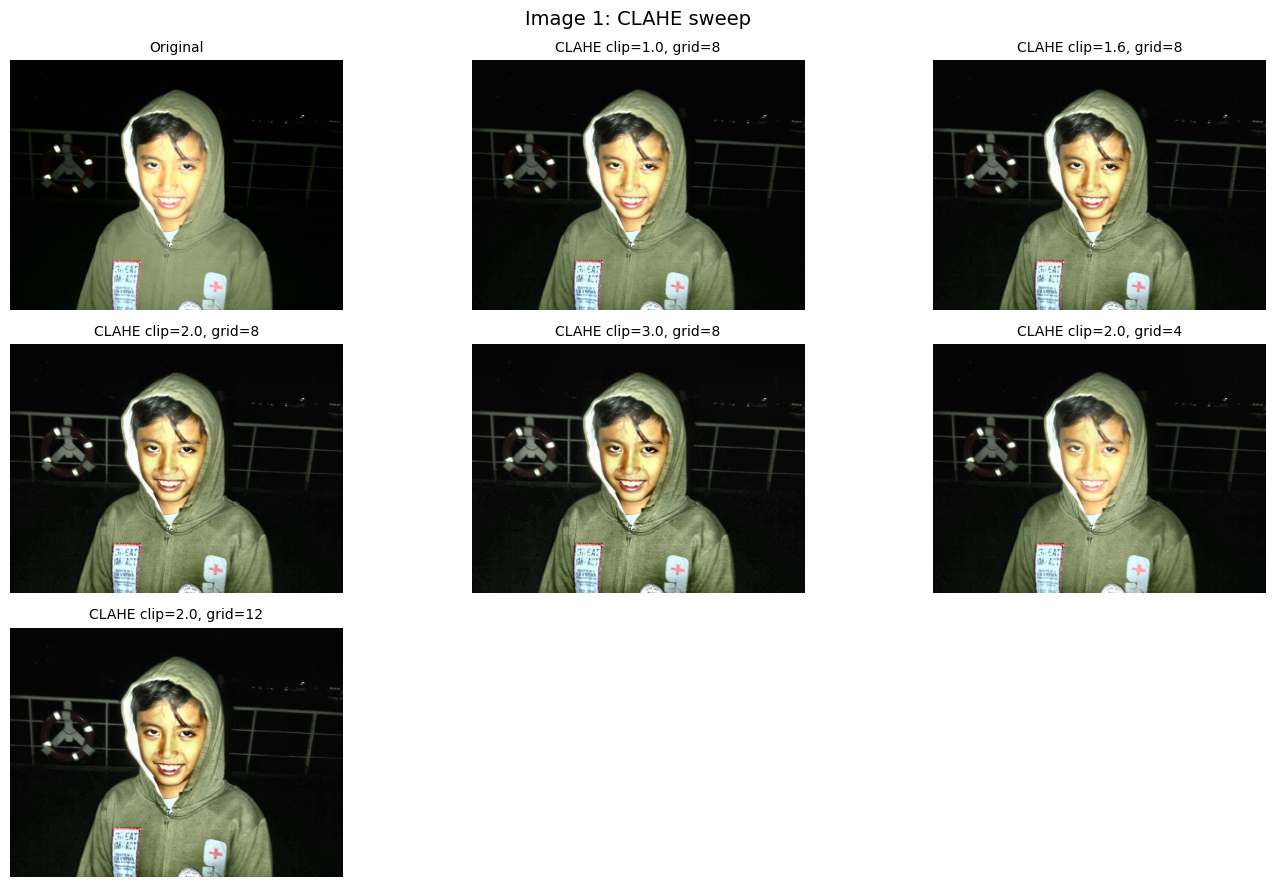

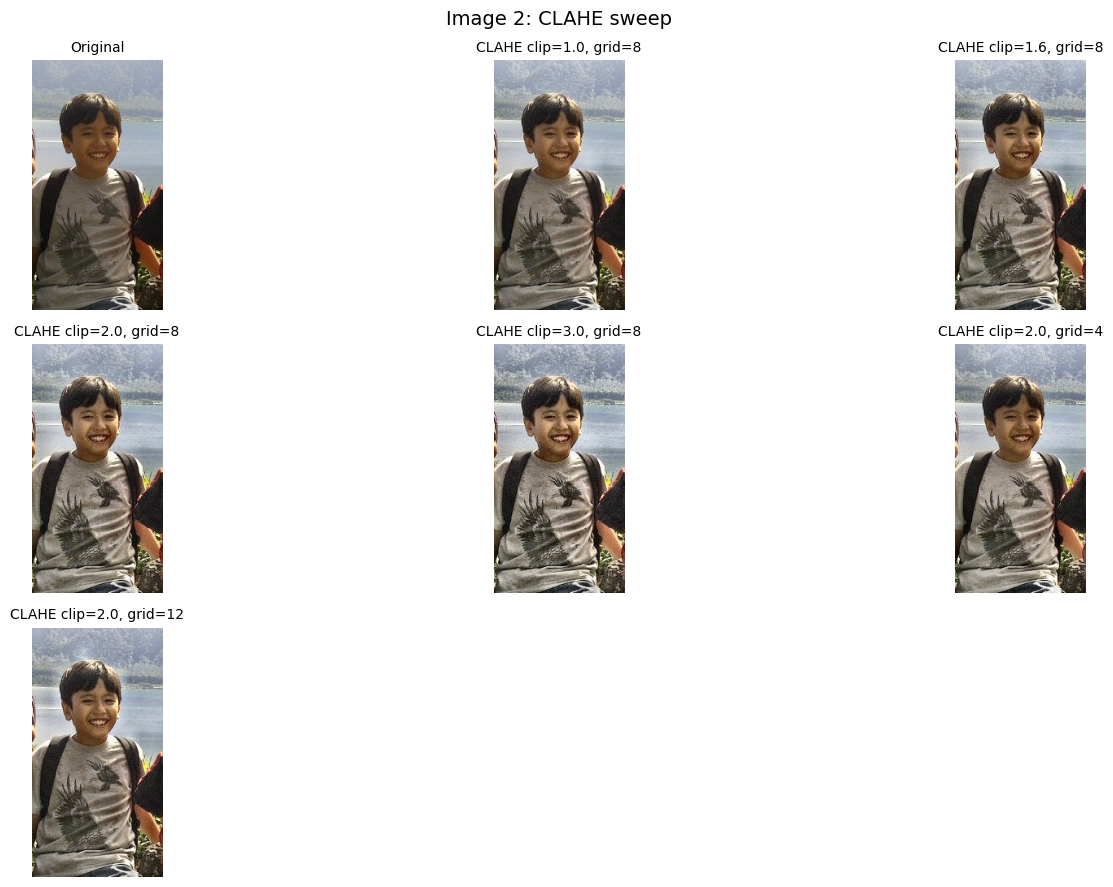

In [34]:
def sweep_clahe(img, params, prefix="img1_clahe", out_dir="./outputs_spatial"):
    ims, titles = [img], ["Original"]
    for cl, grid in params:
        out = clahe_on_luma(img, cl, grid)
        name = f"{prefix}_clip{cl}_grid{grid}"
        ims.append(out)
        titles.append(f"CLAHE clip={cl}, grid={grid}")
    save_version(out, name, out_dir)
    return ims, titles

imgs, titles = sweep_clahe(img1, CLAHE_PARAMS, prefix="image1_clahe")
show_grid(imgs, titles, ncols=3, suptitle="Image 1: CLAHE sweep")

imgs, titles = sweep_clahe(img2, CLAHE_PARAMS, prefix="image2_clahe")
show_grid(imgs, titles, ncols=3, suptitle="Image 2: CLAHE sweep")


# Method 2 - Parameter Sweep – Unsharp Mask

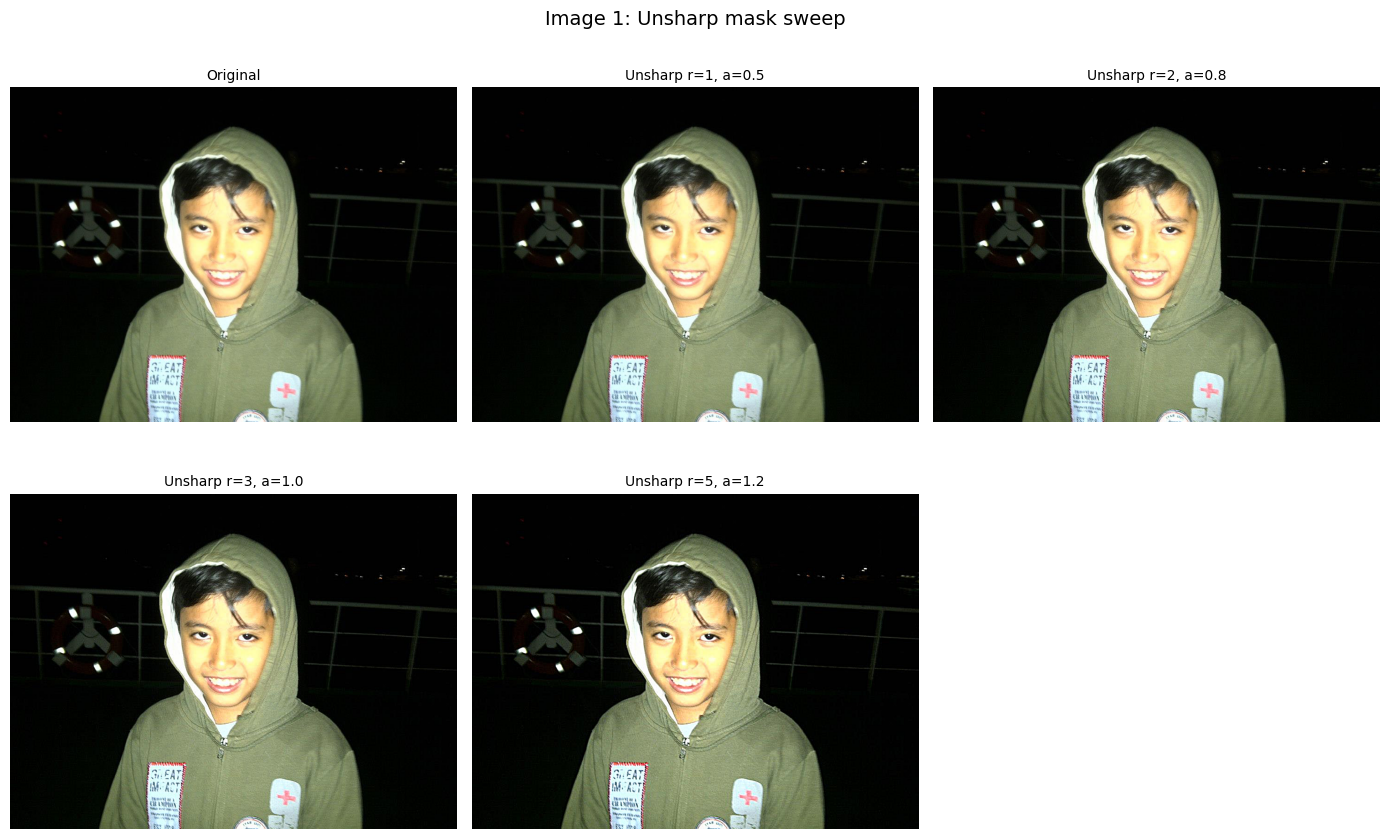

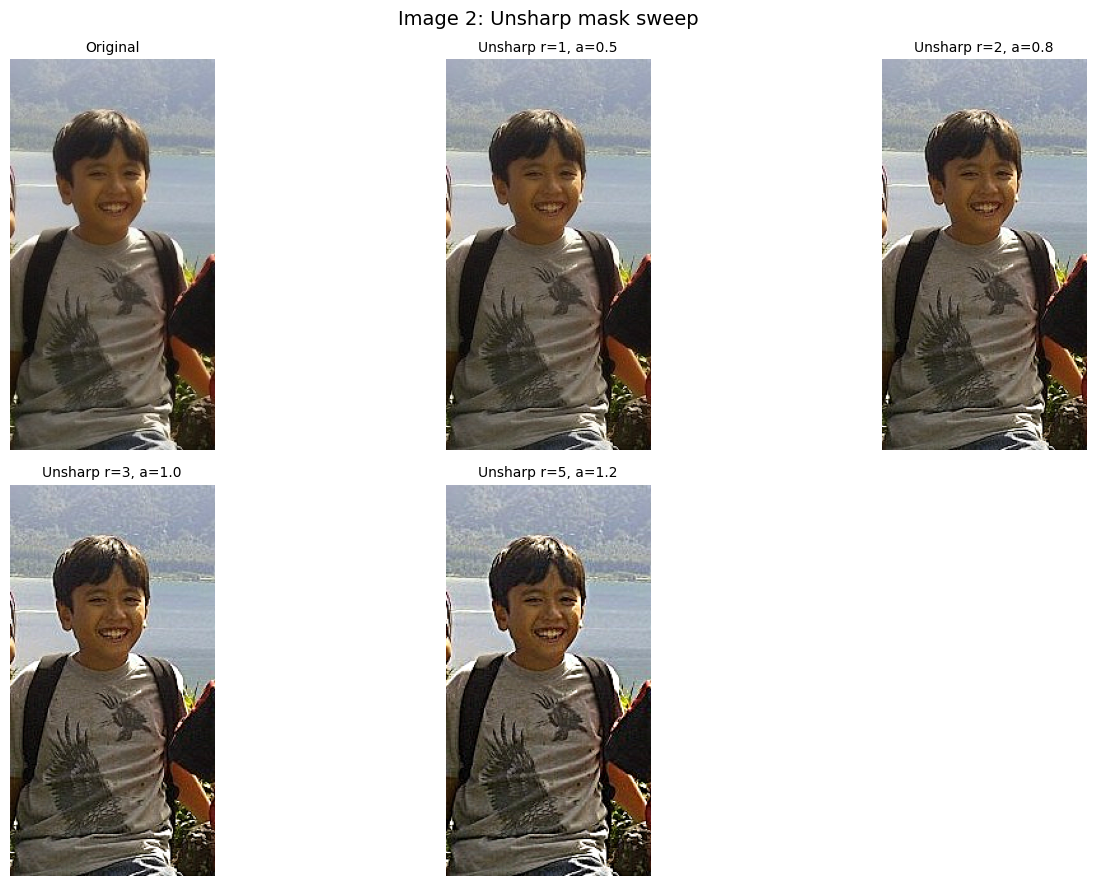

In [35]:
def sweep_unsharp(img, params, prefix="img1_unsharp", out_dir="./outputs_spatial"):
    ims = [img]
    titles = ["Original"]
    for r, a in params:
        out = unsharp_mask(img, r, a)
        name = f"{prefix}_r{r}_a{a}"
        save_version(out, name, out_dir)
        ims.append(out)
        titles.append(f"Unsharp r={r}, a={a}")
    return ims, titles

imgs, titles = sweep_unsharp(img1, UNSHARP_PARAMS)
show_grid(imgs, titles, ncols=3, suptitle="Image 1: Unsharp mask sweep")

imgs, titles = sweep_unsharp(img2, UNSHARP_PARAMS)
show_grid(imgs, titles, ncols=3, suptitle="Image 2: Unsharp mask sweep")


# Method 3 - Parameter Sweep – Gamma & Strech

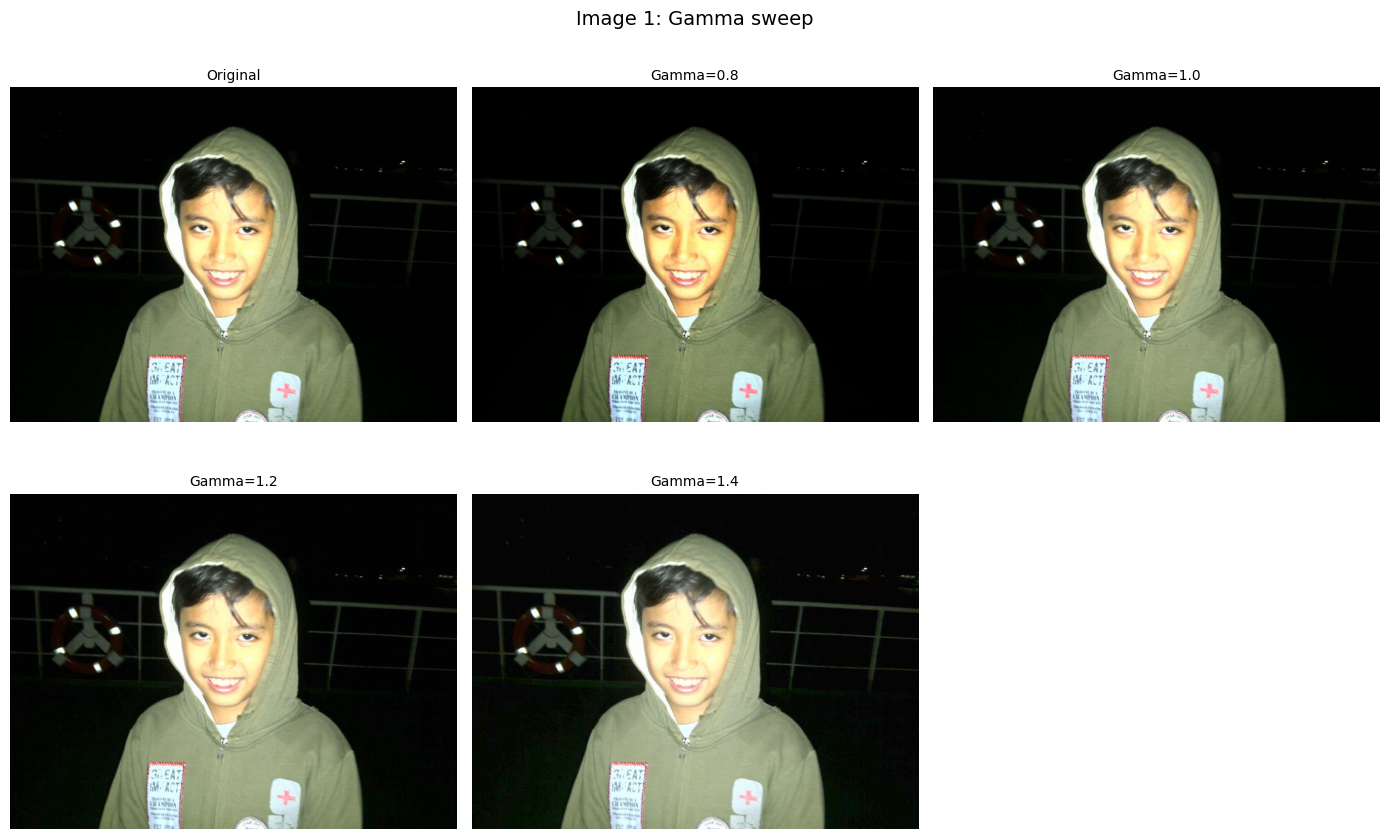

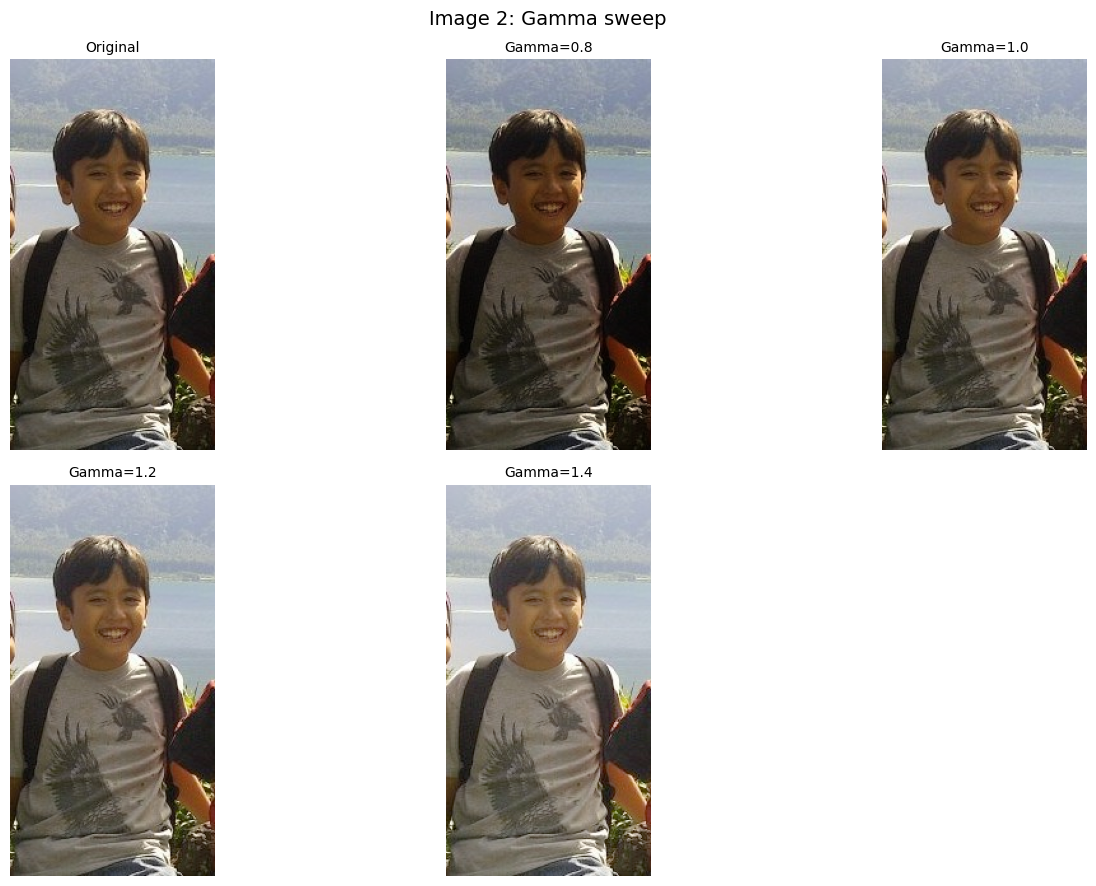

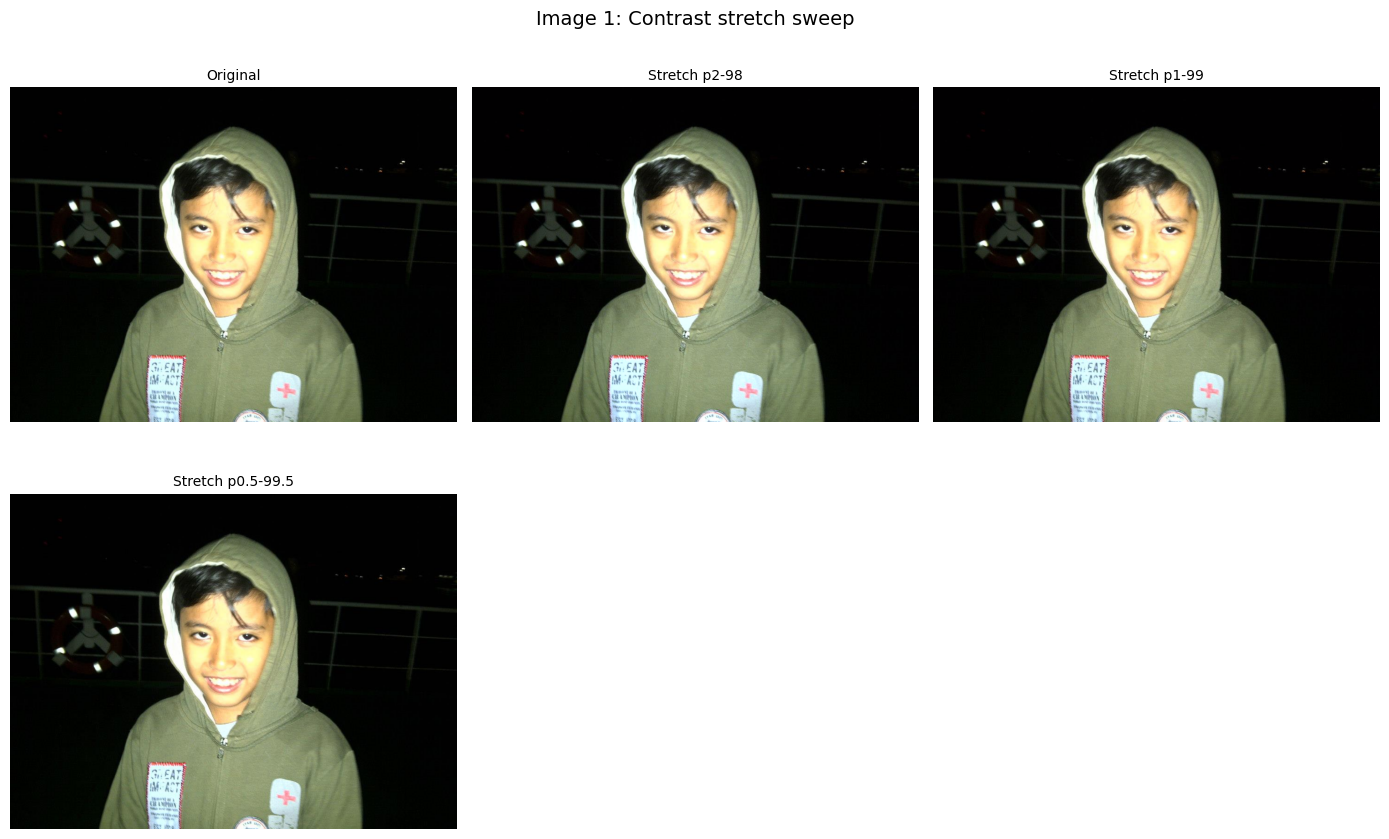

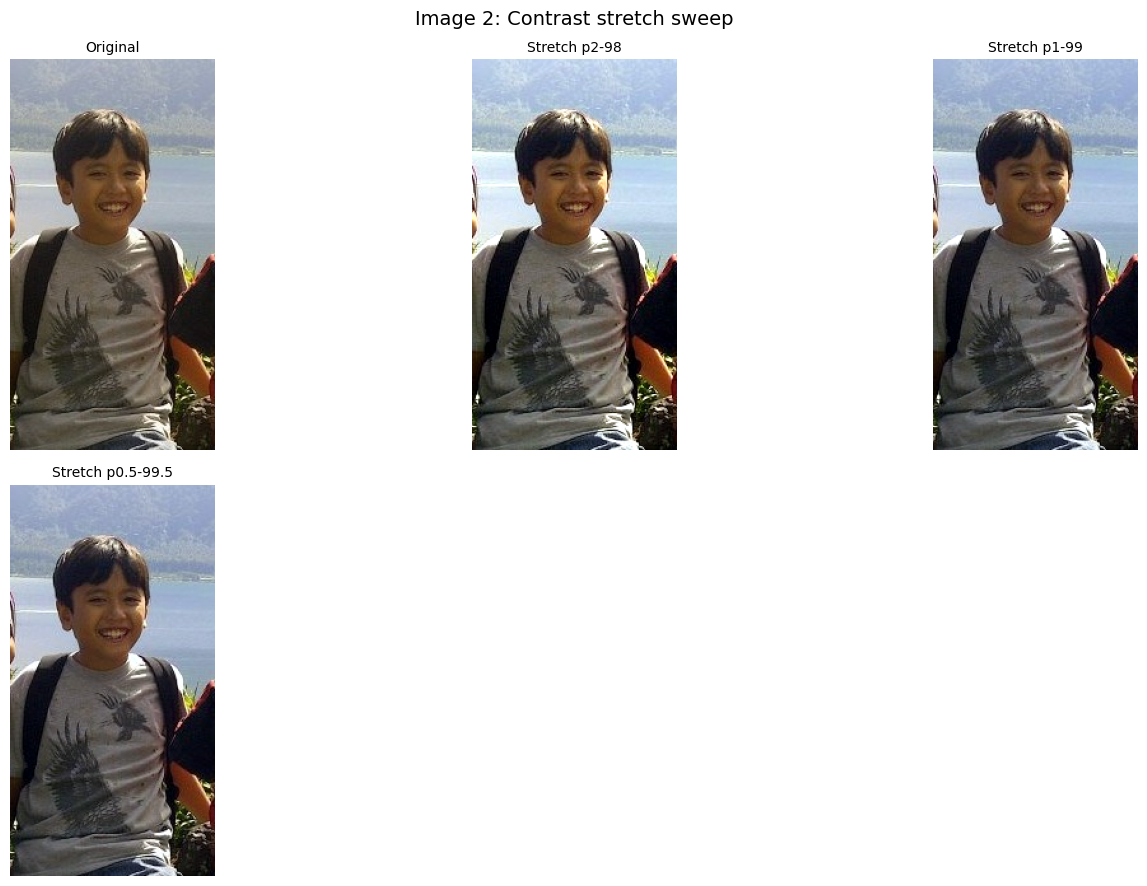

In [36]:
def sweep_gamma(img, gammas):
    ims = [img]
    titles = ["Original"]
    for g in gammas:
        ims.append(gamma_correction(img, g))
        titles.append(f"Gamma={g}")
    return ims, titles

def sweep_contrast_stretch(img, cs_params):
    ims = [img]
    titles = ["Original"]
    for lp, hp in cs_params:
        ims.append(contrast_stretch(img, lp, hp))
        titles.append(f"Stretch p{lp}-{hp}")
    return ims, titles

imgs, titles = sweep_gamma(img1, GAMMA_VALS)
show_grid(imgs, titles, ncols=3, suptitle="Image 1: Gamma sweep")

imgs, titles = sweep_gamma(img2, GAMMA_VALS)
show_grid(imgs, titles, ncols=3, suptitle="Image 2: Gamma sweep")

imgs, titles = sweep_contrast_stretch(img1, CS_PARAMS)
show_grid(imgs, titles, ncols=3, suptitle="Image 1: Contrast stretch sweep")

imgs, titles = sweep_contrast_stretch(img2, CS_PARAMS)
show_grid(imgs, titles, ncols=3, suptitle="Image 2: Contrast stretch sweep")


# Method 4 - Parameter Sweep – Denoise (Bilateral & Median)

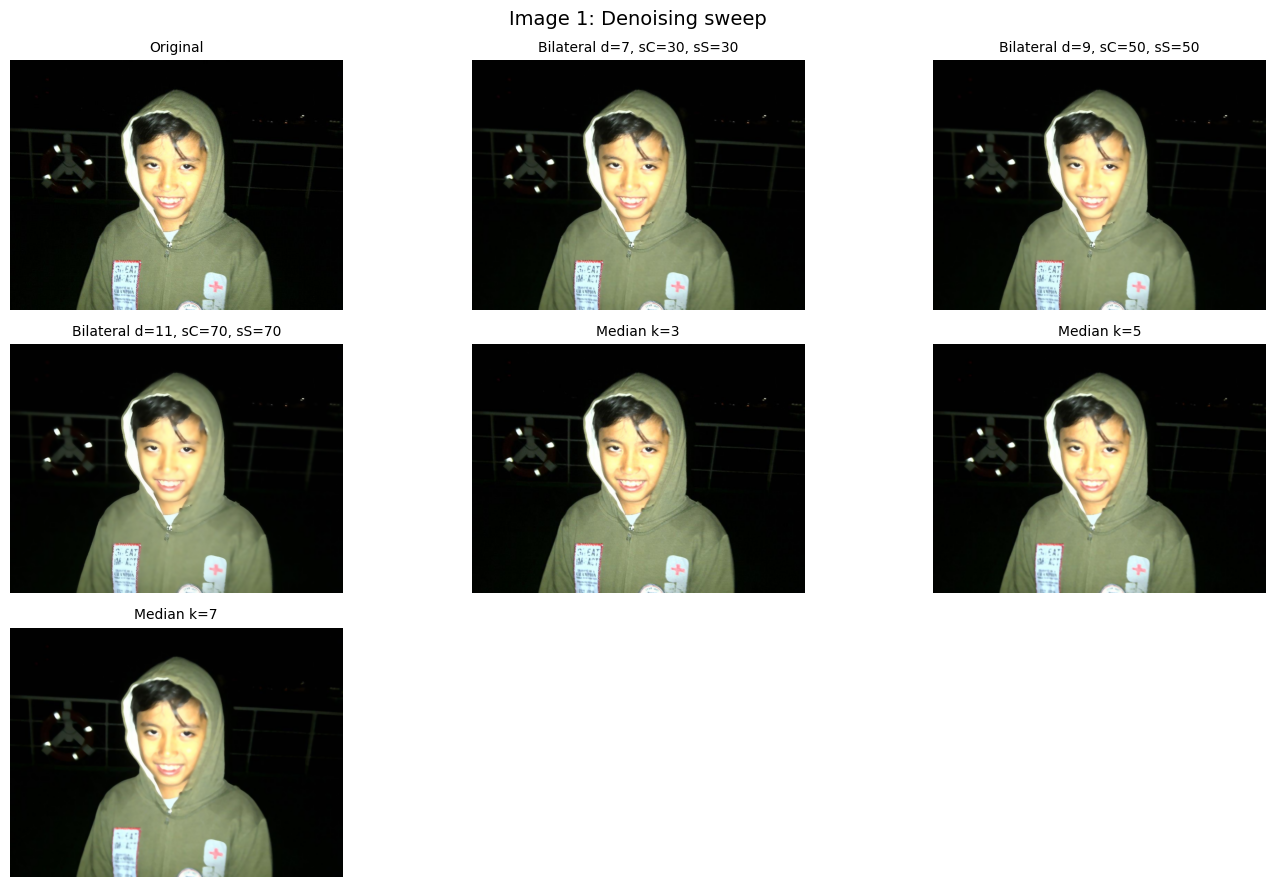

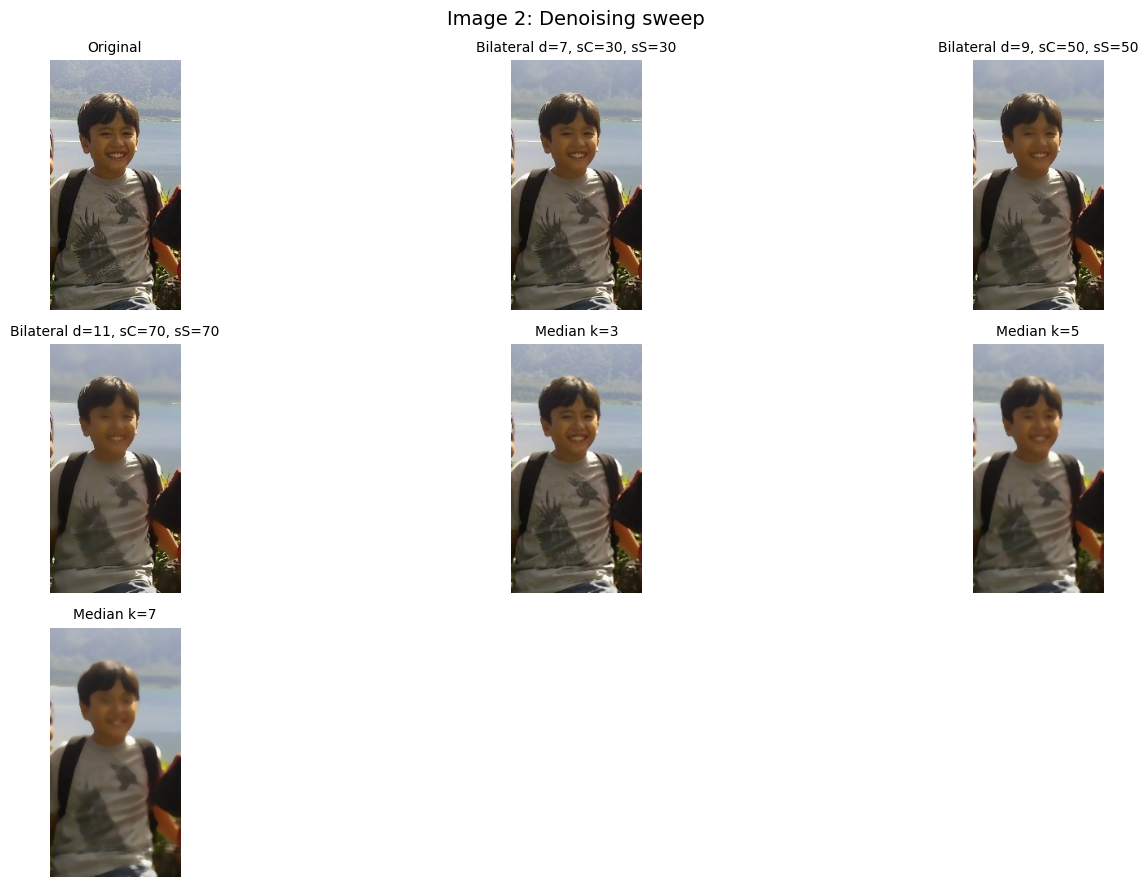

In [37]:
def sweep_denoise(img, bilateral_params, median_params):
    ims = [img]
    titles = ["Original"]
    for d, sc, ss in bilateral_params:
        ims.append(bilateral_denoise(img, d, sc, ss))
        titles.append(f"Bilateral d={d}, sC={sc}, sS={ss}")
    for k in median_params:
        ims.append(median_denoise(img, k))
        titles.append(f"Median k={k}")
    return ims, titles

imgs, titles = sweep_denoise(img1, BILATERAL_PARAMS, MEDIAN_PARAMS)
show_grid(imgs, titles, ncols=3, suptitle="Image 1: Denoising sweep")

imgs, titles = sweep_denoise(img2, BILATERAL_PARAMS, MEDIAN_PARAMS)
show_grid(imgs, titles, ncols=3, suptitle="Image 2: Denoising sweep")


# Result

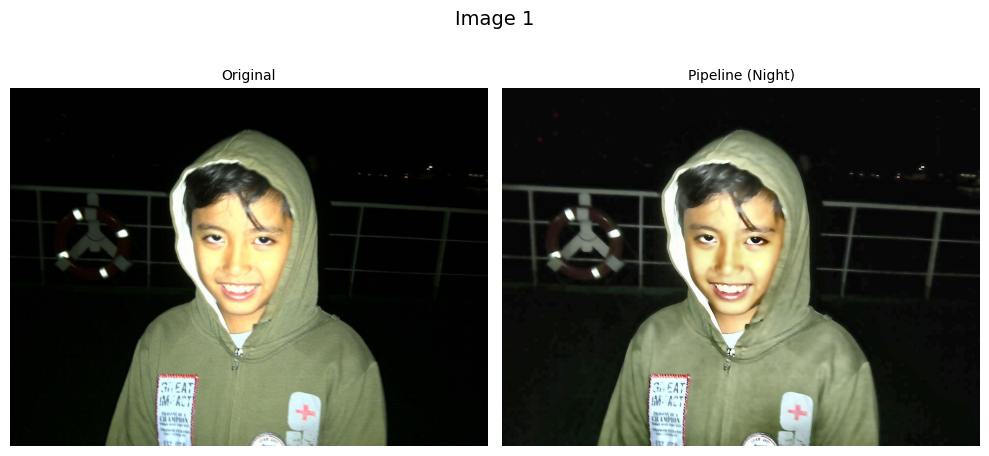

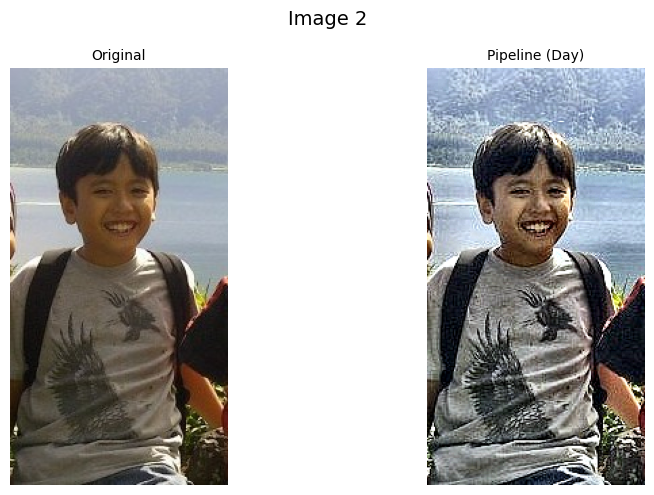

Saved:
- outputs_spatial\image1_night_enhanced.jpg
- outputs_spatial\image2_day_enhanced.jpg


In [38]:

def pipeline_night(img):
    # Malam/flash: denoise -> CLAHE (rendah) -> unsharp ringan -> gamma > 1 (gelapkan highlight)
    a = bilateral_denoise(img, d=9, sigmaColor=50, sigmaSpace=50)
    b = clahe_on_luma(a, clip_limit=1.8, tile_grid_size=8)
    c = unsharp_mask(b, radius=2, amount=0.7)
    d = gamma_correction(c, gamma=1.2)
    return d

def pipeline_day(img):
    # Siang: CLAHE -> contrast stretch -> unsharp
    a = clahe_on_luma(img, clip_limit=2.0, tile_grid_size=8)
    b = contrast_stretch(a, low_percent=1, high_percent=99)
    c = unsharp_mask(b, radius=2, amount=0.9)
    return c

enh1 = pipeline_night(img1)
enh2 = pipeline_day(img2)

# Simpan
out1 = OUT_DIR / "image1_night_enhanced.jpg"
out2 = OUT_DIR / "image2_day_enhanced.jpg"
save_rgb(enh1, out1)
save_rgb(enh2, out2)

# Tampilkan before/after
show_grid([img1, enh1], ["Original", "Pipeline (Night)"], ncols=2, figsize=(10,5), suptitle="Image 1")
show_grid([img2, enh2], ["Original", "Pipeline (Day)"], ncols=2, figsize=(10,5), suptitle="Image 2")

print("Saved:")
print("-", out1)
print("-", out2)
